# Gender Classification by First Name

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [95]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import libraries

In [96]:
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from lr_finder import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
from model import Classifier
import constants

import pickle
import inspect
import helpers

Load the dataset csv and investigate its content

In [97]:
df = pd.read_csv('data/name_gender.csv')
df.head()

,name,gender,probability
0,Aaban,M,1.0
1,Aabha,F,1.0
2,Aabid,M,1.0
3,Aabriella,F,1.0
4,Aada,F,1.0


Remove the `probability` column because it is not needed

In [98]:
df = df.drop('probability', axis=1)
df.head()

,name,gender
0,Aaban,M
1,Aabha,F
2,Aabid,M
3,Aabriella,F
4,Aada,F


See how many names there are

In [99]:
df.shape

(95026, 2)

Remove duplicate names if any

In [100]:
df = df.drop_duplicates(subset='name')
df.shape

(95026, 2)

See the distribution of genders in the dataset

In [101]:
print(df.gender.value_counts())

F    60304
M    34722
Name: gender, dtype: int64


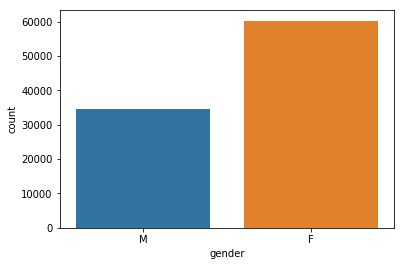

In [102]:
sn.countplot(x='gender', data=df)

Convert both name and gender columns to lists

In [103]:
names = list(df.name)
genders = list(df.gender)

Tokenize names into lists of characters

In [104]:
tokenized_names = list(map(helpers.tokenize_name, names))
tokenized_names[19191]

['d', 'a', 'h', 'l', 't', 'o', 'n']

Build a dictionary that maps characters to integers

In [105]:
all_chars_in_names = [char for chars in tokenized_names for char in chars]
char_counts = Counter(all_chars_in_names)
vocab = sorted(char_counts, key=char_counts.get, reverse=True)
vocab_to_int_map = {char: i for i, char in enumerate(vocab, 1)}
vocab_to_int_map

{'a': 1,
 'e': 2,
 'n': 3,
 'i': 4,
 'r': 5,
 'l': 6,
 's': 7,
 'h': 8,
 'y': 9,
 'o': 10,
 't': 11,
 'd': 12,
 'm': 13,
 'k': 14,
 'c': 15,
 'u': 16,
 'j': 17,
 'b': 18,
 'v': 19,
 'g': 20,
 'z': 21,
 'w': 22,
 'p': 23,
 'f': 24,
 'q': 25,
 'x': 26}

Save vocab dictionary for inference

In [106]:
with open(constants.VOCAB_TO_INT_MAP_PATH, 'wb') as handle:
    pickle.dump(vocab_to_int_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

Numericalize names

In [107]:
numericalized_names = []
for tokenized_name in tokenized_names:
    numericalized_names.append(helpers.numericalize_name(tokenized_name, vocab_to_int_map))

Compare a token to its numerical form

In [108]:
print('Tokenized: {}'.format(tokenized_names[100])) 
print('Numericalized: {}'.format(numericalized_names[100]))

Tokenized: ['a', 'a', 'l', 'e', 'x', 'u', 's']
Numericalized: [1, 1, 6, 2, 26, 16, 7]


Encode labels into integers i.e. 0 and 1

In [109]:
encoded_labels = np.array(list(map(lambda char: 1 if char.lower() == 'm' else 0, genders)))
print('Before: %s' % genders[1])
print('After: %s' % encoded_labels[1])

Before: F
After: 0


Find the range of name lengths so we can use the max as the sequence length across all names

In [110]:
name_lengths = Counter([len(name) for name in numericalized_names])
name_lengths

Counter({5: 15962,
         9: 5268,
         4: 5189,
         7: 24676,
         6: 26436,
         8: 13671,
         12: 215,
         11: 589,
         10: 1698,
         2: 148,
         3: 951,
         14: 62,
         13: 128,
         15: 33})

In [111]:
max_name_length = max(name_lengths)
max_name_length

15

In [112]:
features = helpers.pad_features(numericalized_names, max_name_length)
features[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1, 18,  1,  3])

Split dataset into training, validation, and test sets

In [113]:
split_idx = int(len(features) * 0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

split_idx = int(len(remaining_x) * 0.5)
valid_x, test_x = remaining_x[:split_idx], remaining_x[split_idx:]
valid_y, test_y = remaining_y[:split_idx], remaining_y[split_idx:]

print('Feature shapes:')
print('Training set: {}'.format(train_x.shape))
print('Validation set: {}'.format(valid_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature shapes:
Training set: (76020, 15)
Validation set: (9503, 15)
Test set: (9503, 15)


Prepare dataset to load into the model

In [114]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 128

# shuffle data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [115]:
# get one batch of training data
sample_train_x, sample_train_y = iter(train_loader).next()

print('Sample training input shape: {}'.format(sample_train_x.shape))
print('Sample training input: {}'.format(sample_train_x))

print('Sample training label shape: {}'.format(sample_train_y.shape))
print('Sample training label: {}'.format(sample_train_y))

Sample training input shape: torch.Size([128, 15])
Sample training input: tensor([[ 0,  0,  0,  ..., 11, 11,  1],
        [ 0,  0,  0,  ...,  2,  6,  6],
        [ 0,  0,  0,  ..., 11, 11,  2],
        ...,
        [ 0,  0,  0,  ...,  3,  3,  2],
        [ 0,  0,  0,  ...,  6,  4, 11],
        [ 0,  0,  0,  ..., 10,  9,  1]])
Sample training label shape: torch.Size([128])
Sample training label: tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0])


Check if we are training on a GPU or CPU

In [116]:
is_training_on_gpu = torch.cuda.is_available()

if is_training_on_gpu:
    print('Training on GPU')
else:
    print('Training on CPU')

Training on GPU


Define model

In [117]:
lines = inspect.getsource(Classifier)
print(lines)

class Classifier(nn.Module):
    def __init__(self, sequence_length, num_layers, vocab_size, hidden_dim, output_size):
        '''
        Define model architecture
        '''
        super(Classifier, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        
        self.one_hot_matrix = torch.eye(vocab_size)
        self.lstm = nn.LSTM(vocab_size, hidden_dim, num_layers=num_layers, dropout=0.5, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(p=0.5)
        
    def one_hot_encode(self, labels):
        '''
        Embedding labels to one-hot form
        '''
        if is_training_on_gpu:
            return self.one_hot_matrix[labels].cuda()
        else:
            return self.one_hot_matrix[labels]
        
    def init_hidden_states(self, batch_size):
        '''
        Initialize hidden and cell states
        '''
        weights = 

Initialize model

In [118]:
sequence_length = max_name_length
num_layers = 2
vocab_size = len(vocab) + 1
hidden_dim = 128
output_size = 1
classifier = Classifier(sequence_length, num_layers, vocab_size, hidden_dim, output_size)

See model architecture

In [119]:
print(classifier)

Classifier(
  (lstm): LSTM(27, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)


Use the learning rate finder to find a maximum bound for cyclical learning rate

Use a factor of 10 or 20 less than the maximum bound for the minimum bound if only one cycle is used

Reset model parameters before running LR finder

In [120]:
device = 'cuda' if is_training_on_gpu else 'cpu'
start_lr = 1e-6
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=start_lr)
lr_finder = LRFinder(classifier, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=1000, step_mode='exp')

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


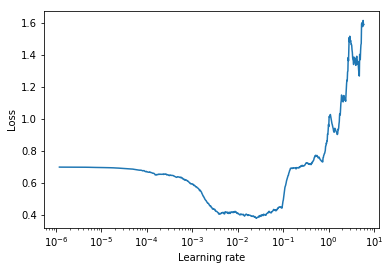

In [121]:
lr_finder.plot()

Reset model parameters

In [122]:
classifier = Classifier(sequence_length, num_layers, vocab_size, hidden_dim, output_size)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-3)

In [123]:
epochs = 10
counter = 0
print_every_n_iterations = 200
max_grad_norm = 5

# transfer model to the appropriate device
if is_training_on_gpu:
    classifier.cuda()

# set the model to training mode
classifier.train()

# stores losses for plotting later
train_losses = []
valid_losses = []

for epoch in range(epochs):
    
    for inputs, labels in train_loader:
        # keep track of number of iterations
        counter += 1
        
        # transfer inputs and labels to the appropriate device
        if is_training_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # reset hidden states
        hidden_states = classifier.init_hidden_states(inputs.shape[0])
        
        # zero accumulated gradients
        classifier.zero_grad()
        
        # get the outputs from the model
        outputs, _ = classifier(inputs, hidden_states)
        
        # calculate loss
        loss = criterion(outputs.squeeze(), labels.float())
        
        # backpropagation
        loss.backward()
        
        # clip gradients
        nn.utils.clip_grad_norm_(classifier.parameters(), max_grad_norm)
        
        # apply gradients
        optimizer.step()
        
        if counter % print_every_n_iterations == 0:
            # accumulate training loss
            train_losses.append(loss)
            
            print('Epoch {}/{}'.format(epoch+1, epochs))
            print('Iteration {} - Training loss: {}'.format(counter, loss))
            
            # set the model to validation mode
            classifier.eval()
            
            total_valid_loss = 0.
            total_valid_accuracy = 0.
            
            for inputs, labels in valid_loader:
                # transfer inputs and labels to the appropriate device
                if is_training_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
                # reset hidden states
                hidden_states = classifier.init_hidden_states(inputs.shape[0])
                
                # get the outputs from the model
                outputs, _ = classifier(inputs, hidden_states)
                
                # calculate loss
                loss = criterion(outputs.squeeze(), labels.float())
                total_valid_loss += loss.item()
                
                # calculate accuracy
                final_outputs = outputs.squeeze().round().cpu().data.numpy()
                final_labels = labels.cpu().data.numpy()
                error_rate = np.sum(np.absolute(final_outputs - final_labels)) / len(final_outputs)
                accuracy = 1 - error_rate
                total_valid_accuracy += accuracy
                
            average_valid_loss = total_valid_loss / len(valid_loader)
            print('Iteration {} - Average validation loss: {}'.format(counter, average_valid_loss))
            
            # accumulate validation loss
            valid_losses.append(average_valid_loss)
            
            average_valid_accuracy = total_valid_accuracy / len(valid_loader)
            print('Iteration {} - Average validation accuracy: {}'.format(counter, average_valid_accuracy))
                
            # reset the model to training mode
            classifier.train()
                

Epoch 1/10
Iteration 200 - Training loss: 0.3591613173484802
Iteration 200 - Average validation loss: 0.3528477621078491
Iteration 200 - Average validation accuracy: 0.8453091397849463
Epoch 1/10
Iteration 400 - Training loss: 0.4155953526496887
Iteration 400 - Average validation loss: 0.3357024027903875
Iteration 400 - Average validation accuracy: 0.8556216397849461
Epoch 2/10
Iteration 600 - Training loss: 0.30108514428138733
Iteration 600 - Average validation loss: 0.3187419114510218
Iteration 600 - Average validation accuracy: 0.8635920698924732
Epoch 2/10
Iteration 800 - Training loss: 0.3315337300300598
Iteration 800 - Average validation loss: 0.31392023622989657
Iteration 800 - Average validation accuracy: 0.8618985215053764
Epoch 2/10
Iteration 1000 - Training loss: 0.4186011254787445
Iteration 1000 - Average validation loss: 0.3057253982623418
Iteration 1000 - Average validation accuracy: 0.8713004032258065
Epoch 3/10
Iteration 1200 - Training loss: 0.20772229135036469
Iterati

Plot iterations x losses

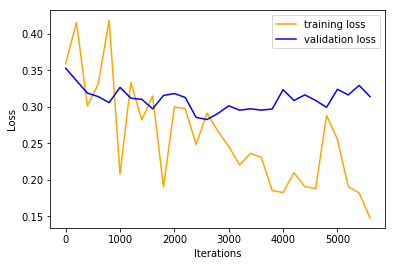

In [124]:
plt.plot(np.arange(len(train_losses)) * print_every_n_iterations, train_losses, color='orange', label='training loss')
plt.plot(np.arange(len(valid_losses)) * print_every_n_iterations, valid_losses, color='blue', label='validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Save model for inference

In [125]:
torch.save({
    'sequence_length': sequence_length,
    'num_layers': num_layers,
    'vocab_size': vocab_size,
    'hidden_dim': hidden_dim,
    'output_size': output_size,
    'model_state_dict': classifier.state_dict()
}, constants.MODEL_PATH)

See how the model performs on the validation set

In [126]:
valid_accuracy, all_valid_outputs, all_valid_labels = helpers.get_model_performance(classifier,
                                                                                    valid_loader,
                                                                                    is_training_on_gpu)

In [127]:
print('Validation accuracy: {}'.format(valid_accuracy))

Validation accuracy: 0.8777228243712512


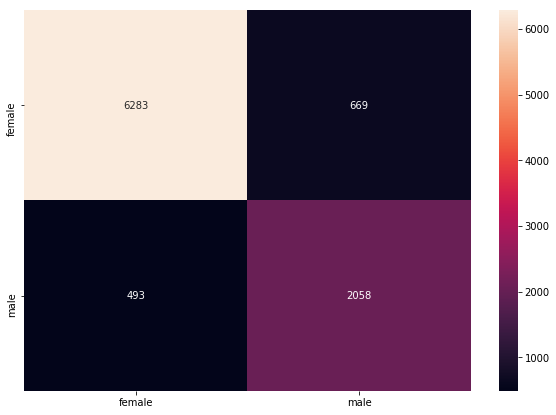

In [128]:
helpers.plot_confusion_matrix(confusion_matrix(all_valid_labels, all_valid_outputs))

See how the model performs on the test set

In [129]:
test_accuracy, all_test_outputs, all_test_labels = helpers.get_model_performance(classifier,
                                                                                 test_loader,
                                                                                 is_training_on_gpu)

In [130]:
print('Test accuracy: {}'.format(test_accuracy))

Test accuracy: 0.8698305798168999


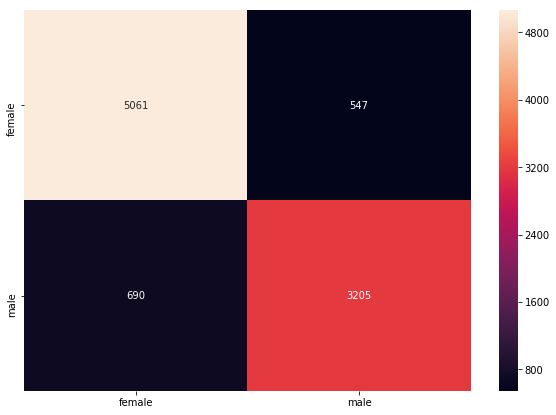

In [131]:
helpers.plot_confusion_matrix(confusion_matrix(all_test_labels, all_test_outputs))

Inference

In [132]:
test_name = 'Margot'
print('{} is {}'.format(test_name, helpers.infer_gender_from_name(test_name, 
                                                                  sequence_length, 
                                                                  vocab_to_int_map, 
                                                                  classifier, 
                                                                  is_training_on_gpu)))

Margot is female
